Advanced Data Science Pipeline for WiDS Datathon 2025

## Objective
Develop a robust machine learning pipeline focusing on ADHD prediction and gender classification using advanced feature engineering (FE), exploratory data analysis (EDA), and machine learning (ML) techniques.


Importance:

ADHD diagnosis is particularly challenging in females. By identifying distinct brain activity patterns, this study can guide personalized therapies and early interventions.


Key Outcomes

1. Data Cleaning & Preprocessing: Handling missing values, outliers, and inconsistencies.
2. Understanding Correlations: Analyzing relationships between features and targets.
3. Regression Model Selection: Choosing optimal statistical and machine learning models.
4. Model Fitting & Testing: Applying cross-validation, avoiding over/underfitting, and using stratified data splitting.
5. Explaining Model Performance: Identifying key factors driving predictions.
6. Multi-Outcome Prediction: Training models for both ADHD and gender classification.

## Step 1: Loading and Merging Data

- Load the multiple datasets: train, test, categorical metadata, quantitative metadata, functional connectome matrices, and training solutions.
- Merge data on common identifiers.
- Handle missing values and standardize formats.

### Summary of the Dataset:
##### Categorical Metadata (10 columns, 1213 entries)

Contains participant demographic data, study site information, and family background.

Includes fields such as ethnicity, race, scan location, and parental education/occupation.

One column (PreInt_Demos_Fam_Child_Ethnicity) has 11 missing values.

##### Quantitative Metadata (19 columns, 1213 entries)

Contains brain-related and behavioral test scores.

Includes assessments like Edinburgh Handedness Questionnaire (EHQ), Color Vision, Alabama Parenting Questionnaire (APQ), and Strengths and Difficulties Questionnaire (SDQ).

The column MRI_Track_Age_at_Scan has missing 360 missing values.


##### Training Solutions (3 columns, 1213 entries)

Contains data related to the outcome

Whether a patient was diagnosed with ADHD and the gender of the patient

In [1]:
## import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [2]:

# Load datasets
train_categorical = pd.read_excel("TRAIN\TRAIN_CATEGORICAL_METADATA.xlsx")
train_quantitative = pd.read_excel("TRAIN\TRAIN_QUANTITATIVE_METADATA.xlsx")
train_connectome = pd.read_csv("TRAIN\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")
train_labels = pd.read_excel("TRAIN\TRAINING_SOLUTIONS.xlsx")

# Merge datasets
train_data = pd.merge(train_categorical, train_quantitative, on='participant_id')
train_data = pd.merge(train_data, train_connectome, on='participant_id')
train_data = train_data.merge(train_labels, on='participant_id')

In [3]:
# Drop non-useful columns
train_data.drop(['participant_id'], axis=1, inplace=True)

In [4]:
# Identify missing values
missing_values = train_data.isnull().sum().sort_values(ascending=False)
print("Missing Values:\n", missing_values[missing_values > 0])

Missing Values:
 MRI_Track_Age_at_Scan               360
PreInt_Demos_Fam_Child_Ethnicity     11
dtype: int64


In [5]:
print("Columns of the training data: ", train_data.columns)

Columns of the training data:  Index(['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total',
       ...
       '195throw_198thcolumn', '195throw_199thcolumn', '196throw_197thcolumn',
       '196throw_198thcolumn', '196throw_199thcolumn', '197throw_198thcolumn',
       '197throw_199thcolumn', '198throw_199thcolumn', 'ADHD_Outcome',
       'Sex_F'],
      dtype='object', length=19929)


In [6]:
# Handle missing values
train_data.fillna(train_data.median(), inplace=True)

In [7]:
train_data.head()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
0,2016,1,0.0,0,1,21,45,21,45,40.00,...,-0.058396,-0.041544,0.142806,-0.006377,0.108005,0.148327,0.093230,-0.004984,1,1
1,2019,3,1.0,2,3,15,15,0,0,-94.47,...,-0.025624,-0.031863,0.162011,0.067439,0.017155,0.088893,0.064094,0.194381,1,0
2,2016,1,1.0,8,1,18,40,0,0,-46.67,...,0.010771,-0.044341,0.128386,0.047282,0.087678,0.146221,-0.009425,0.035150,1,0
3,2018,3,0.0,8,3,15,30,18,0,-26.68,...,-0.007152,0.032584,0.121726,0.045089,0.154464,0.106817,0.065336,0.234708,1,1
4,2019,3,0.0,1,3,15,20,0,0,0.00,...,-0.010196,0.035638,0.074978,0.030579,0.025640,0.118199,0.112522,0.143666,1,1


In [8]:
train_data.tail()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ,EHQ_EHQ_Total,...,195throw_198thcolumn,195throw_199thcolumn,196throw_197thcolumn,196throw_198thcolumn,196throw_199thcolumn,197throw_198thcolumn,197throw_199thcolumn,198throw_199thcolumn,ADHD_Outcome,Sex_F
1208,2019,1,0.0,0,2,21,40,21,40,87.80,...,0.030852,-0.009849,0.213448,0.101271,0.054290,0.101367,0.159979,0.149812,0,0
1209,2016,1,0.0,0,1,18,35,0,0,77.80,...,-0.096499,0.075038,0.050760,0.103528,0.093136,-0.029158,0.084720,0.135419,0,1
1210,2015,1,1.0,2,1,18,20,0,0,16.68,...,-0.058516,-0.030533,0.103685,0.005338,0.051195,0.051761,0.010093,0.117584,0,1
1211,2018,3,0.0,8,3,21,40,18,45,53.40,...,0.035906,0.027778,0.059302,0.047181,0.093942,0.115655,0.106790,0.117870,0,0
1212,2018,3,1.0,2,2,21,40,18,45,-57.80,...,-0.061029,0.117004,0.162324,0.003006,-0.029927,-0.017830,0.062416,0.161122,0,0


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Columns: 19929 entries, Basic_Demos_Enroll_Year to Sex_F
dtypes: float64(19903), int64(26)
memory usage: 184.4 MB


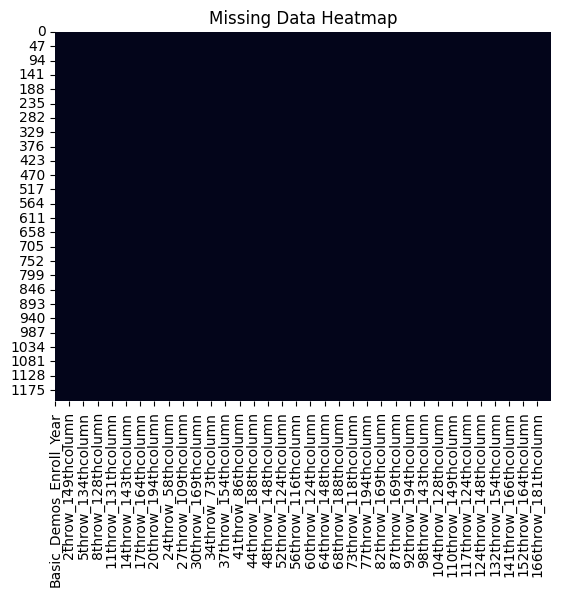

In [10]:
# Visualize missing data
sns.heatmap(train_data.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()


 🔍 Understanding Correlation in Our Data

Correlation analysis helps us measure the strength and direction of relationships between numerical variables in our dataset. This is crucial in understanding how different features interact with each other and with our target variables.

### 📌 What Are We Correlating?
In this dataset, we are primarily interested in numerical features, including:
- Neuroimaging data (from functional connectome matrices)
- Quantitative metadata (e.g., age, cognitive test scores)
- Target variables(ADHD_Outcome, Sex_F)

By computing correlations, we can uncover patterns such as:
- 🧠 Do functional connectivity patterns relate to ADHD diagnosis?
- 🔢 Does age correlate with cognitive performance or ADHD outcomes?
- 🏥 Are certain brain connectivity features linked to gender differences?

### 🚫 What Should NOT Be Correlated?
Not all variables are suitable for correlation analysis:
- Participant ID → It’s a unique identifier and does not hold meaningful relationships.
- Categorical Features (e.g., Handedness, Parent Education Level) → These need encoding before any numerical correlation analysis.

### 📊 How We Compute Correlations
Since correlation measures numerical relationships, we will first filter out non-numeric features and then compute correlations.

In [11]:
# Select only numeric features (excluding IDs and categorical columns)
numeric_data = train_data.select_dtypes(include=['number'])

In [12]:
# Reduce data size by sampling (adjust frac if needed)
sampled_data = numeric_data.sample(frac=0.10, random_state=42)  # 10% sampling for speed 

In [13]:
# Compute Spearman correlation matrix (better for non-linear data)
corr_matrix = sampled_data.corr(method='spearman')


In [14]:
# Compute correlation only for the top 30 features (if too slow, reduce further)
corr_matrix = sampled_data.iloc[:, :30].corr()


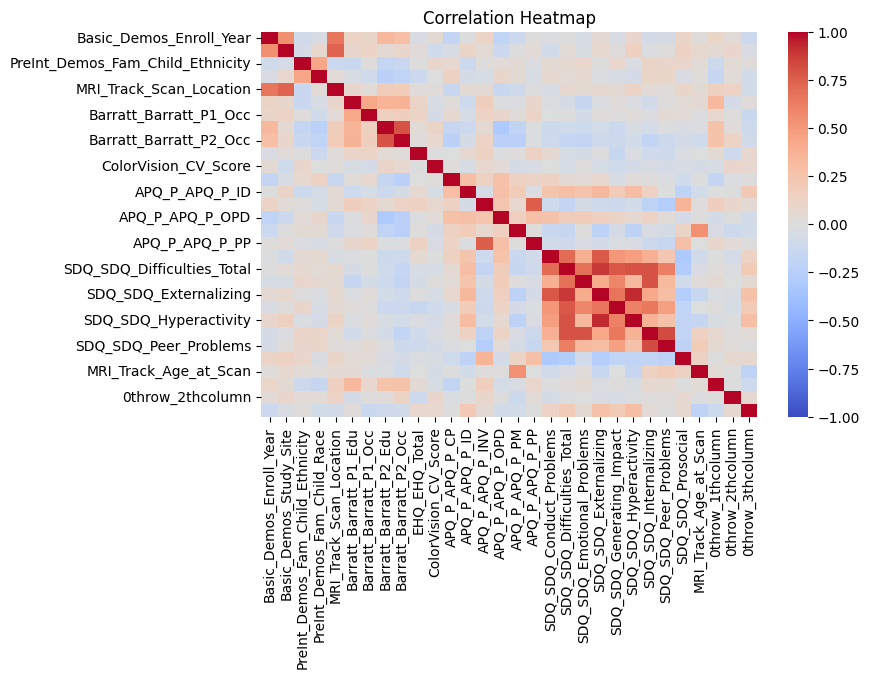

In [15]:

# Plot optimized heatmap (smaller, faster rendering)
plt.figure(figsize=(8, 5))  # Smaller size for speed
sns.heatmap(
    corr_matrix, 
    cmap='coolwarm', 
    vmax=1, vmin=-1,  # Clamping values speeds up rendering
    cbar=True, 
    annot=False,  # No annotations to speed up
    square=False   # Saves memory
)
plt.title("Correlation Heatmap")
plt.show()


In [16]:
# Summary of categorical variables
categorical_cols = ['Sex_F', 'ADHD_Outcome']  
for col in categorical_cols:
    print(f"\n{col} Distribution:\n", train_data[col].value_counts())


Sex_F Distribution:
 Sex_F
0    797
1    416
Name: count, dtype: int64

ADHD_Outcome Distribution:
 ADHD_Outcome
1    831
0    382
Name: count, dtype: int64


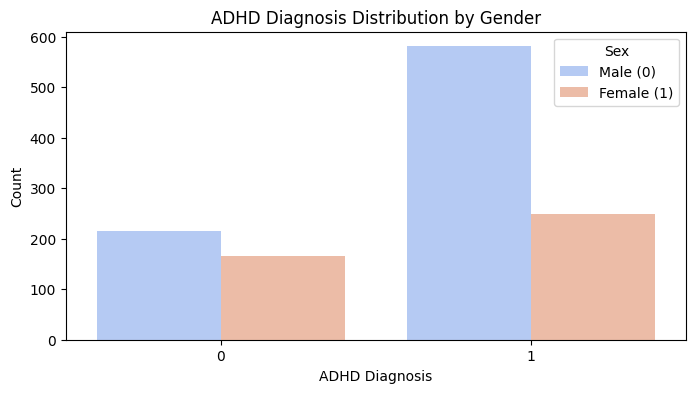

In [17]:
plt.figure(figsize=(8,4))
sns.countplot(x='ADHD_Outcome', hue='Sex_F', data=train_data, palette='coolwarm')
plt.title("ADHD Diagnosis Distribution by Gender")
plt.xlabel("ADHD Diagnosis")
plt.ylabel("Count")
plt.legend(title="Sex", labels=["Male (0)", "Female (1)"])
plt.show()


Feature Variables

1. **Brain Connectivity Data**
  - fMRI connectome matrices (~19,900 features)
  - Brain region correlation values

2. **Psychological Assessment Scores**
  - Strength and Difficulties Questionnaire (SDQ) - 9 scores
  - Measures of emotional problems, behavioral issues, hyperactivity, peer problems

3. **Parenting Measures**
  - Alabama Parenting Questionnaire (APQ) - 6 scores
  - Parental discipline, involvement, monitoring styles

4. **Clinical Measures**
  - Handedness (Edinburgh Handedness Questionnaire)
  - Color vision ability

5. **Demographic Information**
  - Enrollment year
  - Study site location
  - Child's ethnicity and race
  - Parent's education level

1. Brain Connectivity Data (fMRI Connectome Matrices)

📍 Since this dataset contains thousands of features (~19,900), we need dimensionality reduction techniques before visualization.

🔹 t-SNE / PCA Visualization of Brain Connectivity Patterns
This helps visualize clusters in high-dimensional fMRI data.

python
Copy
Edit




In [18]:
# Ensure fMRI columns are numerical and handle missing values
fmri_columns = [col for col in train_data.columns if 'fmri' in col.lower()]
train_data[fmri_columns] = train_data[fmri_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

In [19]:
print("=== BRAIN CONNECTIVITY ANALYSIS ===")

# 1. Identify brain connectivity features
connectome_cols = [col for col in train_data.columns if (col.startswith('0throw') or 
                                                    col.startswith('1throw') or 
                                                    col.startswith('2throw'))]
print(f"Number of brain connectivity features: {len(connectome_cols)}")
print(f"First few connectivity features: {connectome_cols[:5]}")


=== BRAIN CONNECTIVITY ANALYSIS ===
Number of brain connectivity features: 594
First few connectivity features: ['0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn']


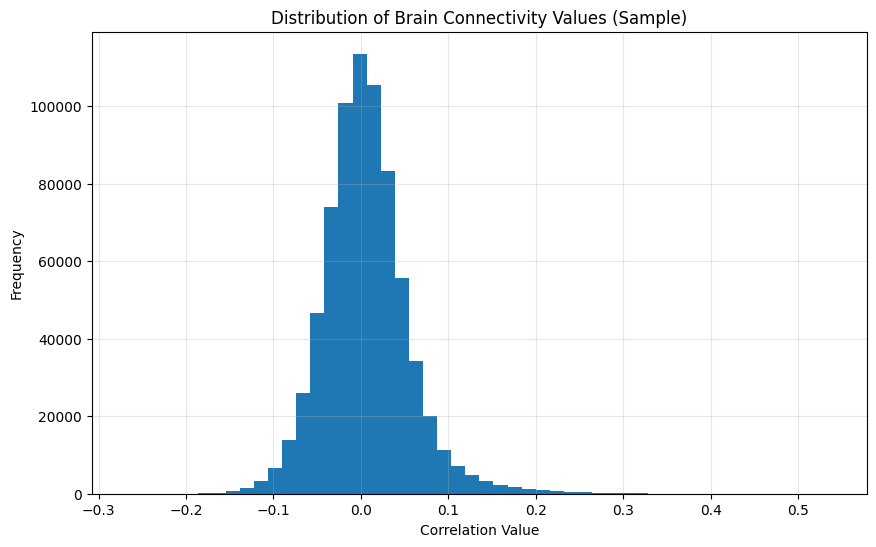

In [20]:
# 2. Distribution of connectivity values (sample)
plt.figure(figsize=(10, 6))
# Take a random sample to avoid memory issues
sample_size = min(1000, len(connectome_cols))
np.random.seed(42)
sample_cols = np.random.choice(connectome_cols, sample_size)
all_values = train_data[sample_cols].values.flatten()
all_values = all_values[~np.isnan(all_values)]  # Remove NaN values if any

plt.hist(all_values, bins=50)
plt.title('Distribution of Brain Connectivity Values (Sample)')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()


Key Insights from the brain scans with regards to gender differences:


1️⃣ ADHD & Brain Connectivity Patterns


The bell-shaped distribution suggests that most brain connections show weak correlations (near zero).



This aligns with the ADHD-related research, where weaker or disrupted functional connectivity is often observed, especially in regions responsible for attention and impulse control.


If you compare ADHD vs. non-ADHD groups, you might find that ADHD brains have a wider spread or more extreme values, indicating dysregulated connectivity.

🌟 Subtle Variability Observations
Peak Heights & Spread

The curves aren’t perfectly identical—one seems slightly higher than the other.

This suggests that while both distributions are centered around zero, the spread (variance) or density at specific values might differ between genders.
Possible Differences in Tails

If one gender has a slightly longer tail, it could mean that some individuals in that group have more extreme connectivity values (either stronger or weaker correlations).

Overlap Doesn’t Mean No Difference


KDE plots can mask subtle statistical differences. Even if the curves look similar, a t-test or effect size analysis could reveal meaningful differences in the means or distributions.

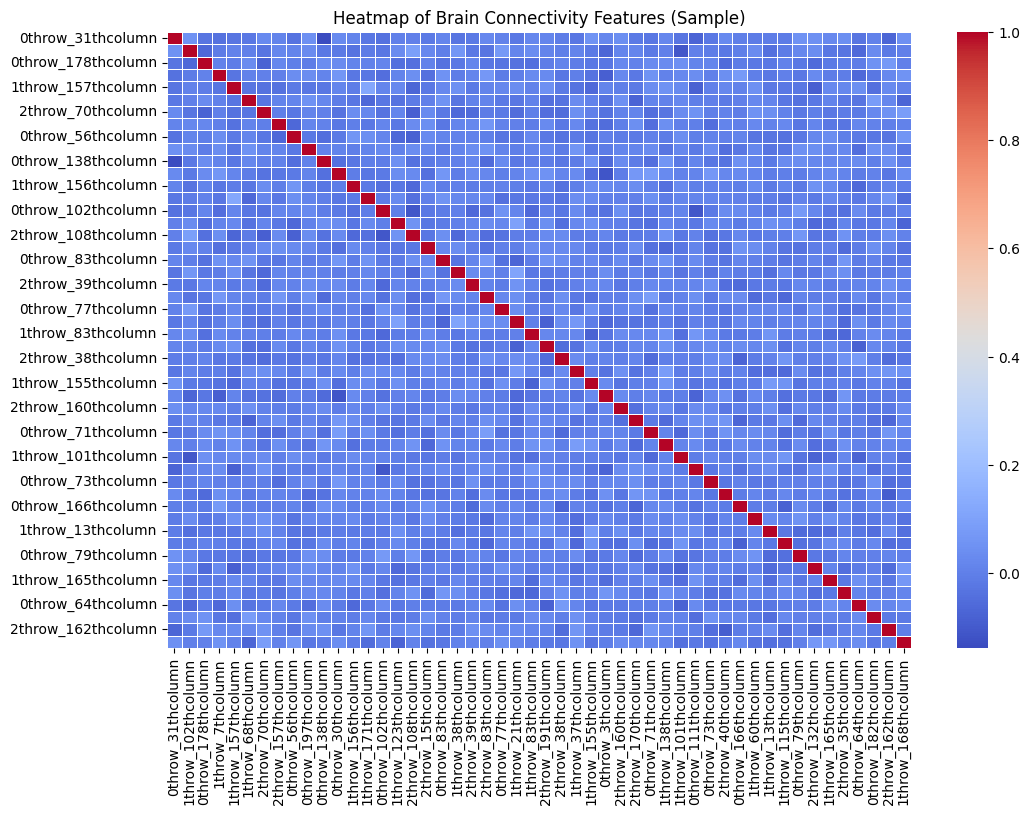

In [21]:
import seaborn as sns

# Take a smaller subset to avoid memory issues
heatmap_sample_size = min(50, len(connectome_cols))  # Adjust based on dataset size
np.random.seed(42)
heatmap_sample_cols = np.random.choice(connectome_cols, heatmap_sample_size, replace=False)

# Compute correlation matrix
connectivity_corr = train_data[heatmap_sample_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(connectivity_corr, cmap="coolwarm", annot=False, fmt=".2f", linewidths=0.5)
plt.title('Heatmap of Brain Connectivity Features (Sample)')
plt.show()


In [22]:
# 3. Simple visualization of connectivity difference between ADHD and non-ADHD
# Take just 20 random features for a simple comparison
sample_size = 20
np.random.seed(42)
tiny_sample = np.random.choice(connectome_cols, sample_size)

In [23]:

# Calculate means by group
adhd_means = train_data[train_data['ADHD_Outcome']==1][tiny_sample].mean()
non_adhd_means = train_data[train_data['ADHD_Outcome']==0][tiny_sample].mean()
diff = adhd_means - non_adhd_means


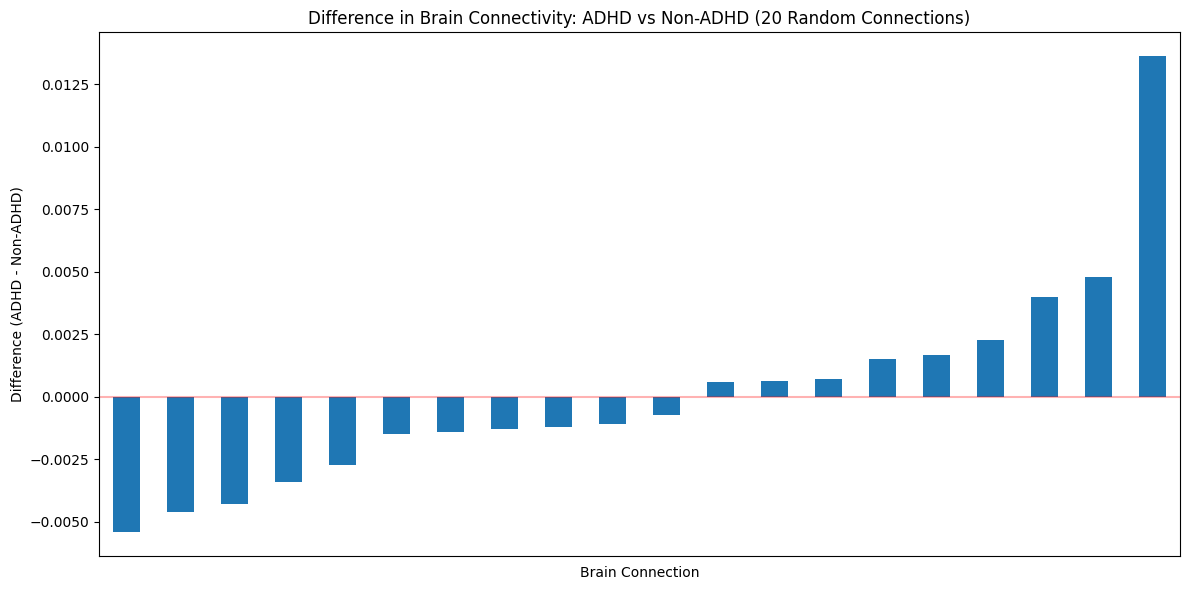

In [24]:

# Plot differences
plt.figure(figsize=(12, 6))
diff.sort_values().plot(kind='bar')
plt.title('Difference in Brain Connectivity: ADHD vs Non-ADHD (20 Random Connections)')
plt.xlabel('Brain Connection')
plt.ylabel('Difference (ADHD - Non-ADHD)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks([])  # Hide feature names to avoid clutter
plt.tight_layout()
plt.show()


### **Explanation of the Bar Chart:**
This plot shows the **difference in brain connectivity** between individuals with ADHD and those without ADHD across **20 randomly selected brain connections**. 

- The **y-axis** represents the difference in brain connectivity values (`ADHD - Non-ADHD`).
- The **x-axis** represents different brain connections.
- The **red line at zero** serves as a baseline; bars above this line indicate that individuals with ADHD have higher connectivity in that connection, while bars below indicate lower connectivity.

---

### **Key Insights:**
1. **Variability in Connectivity Differences:**  
   - Some connections show **higher connectivity in ADHD** (positive bars), while others show **reduced connectivity** (negative bars).  
   - This suggests that ADHD may not uniformly increase or decrease connectivity but instead alters it differently across brain regions.

2. **Asymmetry in Differences:**  
   - The **largest positive bar** suggests that a specific brain connection has a notably higher connectivity in ADHD individuals compared to non-ADHD individuals.  
   - Conversely, the **largest negative bar** indicates a connection where ADHD individuals show significantly lower connectivity.

3. **Possible Functional Implications:**  
   - Increased connectivity in certain regions could indicate **hyperactivity or compensatory mechanisms** in the ADHD brain.  
   - Decreased connectivity may suggest **weaker neural coordination** in areas related to attention regulation.

4. **Next Steps for Analysis:**  
   - **Statistical Testing** (e.g., t-tests or ANOVA) to determine if these differences are statistically significant.  
   - **Brain Region Mapping** to identify which functional networks are most affected.  
   - **Correlations with Symptoms** to understand whether connectivity differences align with behavioral characteristics of ADHD.



=== EXPOUNDING BRAIN CONNECTIVITY DATA ===
Number of brain connectivity features: 594
First few connectivity features: ['0throw_1thcolumn', '0throw_2thcolumn', '0throw_3thcolumn', '0throw_4thcolumn', '0throw_5thcolumn']

What do these features mean?
- Each feature (like '0throw_1stcolumn') represents the correlation between two brain regions
- Values range from -1 to +1
- Positive values: regions activate together
- Negative values: when one region activates, the other tends to deactivate
- Values close to zero: little relationship between regions

=== SAMPLE BRAIN CONNECTIVITY VALUES ===
For the first subject in our dataset:
0throw_1thcolumn: -0.0398
0throw_2thcolumn: 0.1776
0throw_3thcolumn: 0.0572
0throw_4thcolumn: 0.0376
0throw_5thcolumn: 0.1182


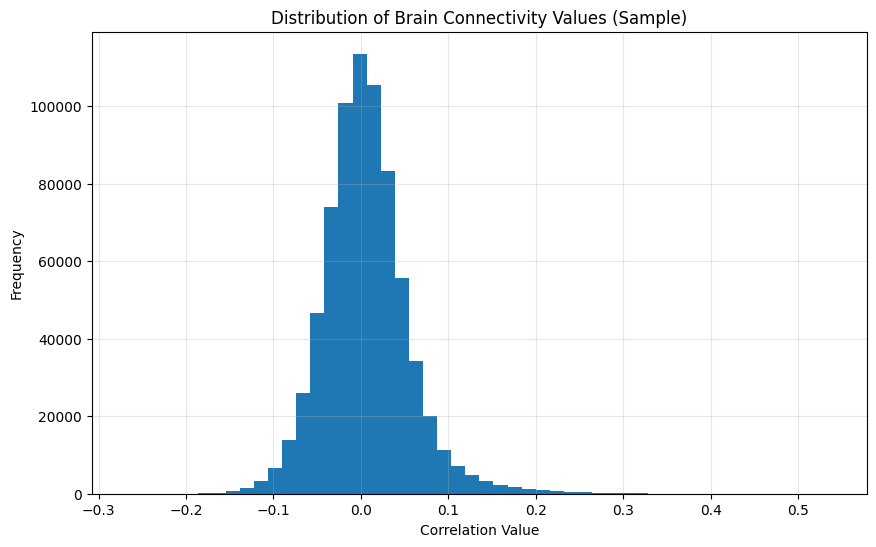


The histogram shows us how brain connectivity values are distributed.
Most values are centered around zero, with fewer strong positive or negative correlations.

=== COMPARING BRAIN CONNECTIVITY: ADHD VS NON-ADHD ===
                      ADHD  Non-ADHD  Difference
0throw_103thcolumn  0.0164    0.0028      0.0136
2throw_41thcolumn  -0.0064   -0.0010     -0.0054
1throw_73thcolumn   0.0084    0.0112     -0.0027
0throw_107thcolumn -0.0033   -0.0022     -0.0011
0throw_72thcolumn  -0.0008   -0.0014      0.0007
0throw_21thcolumn   0.0022    0.0065     -0.0043
0throw_122thcolumn -0.0013   -0.0001     -0.0012
2throw_72thcolumn   0.0111    0.0124     -0.0013
1throw_17thcolumn   0.0024   -0.0016      0.0040
1throw_133thcolumn  0.0035    0.0012      0.0023


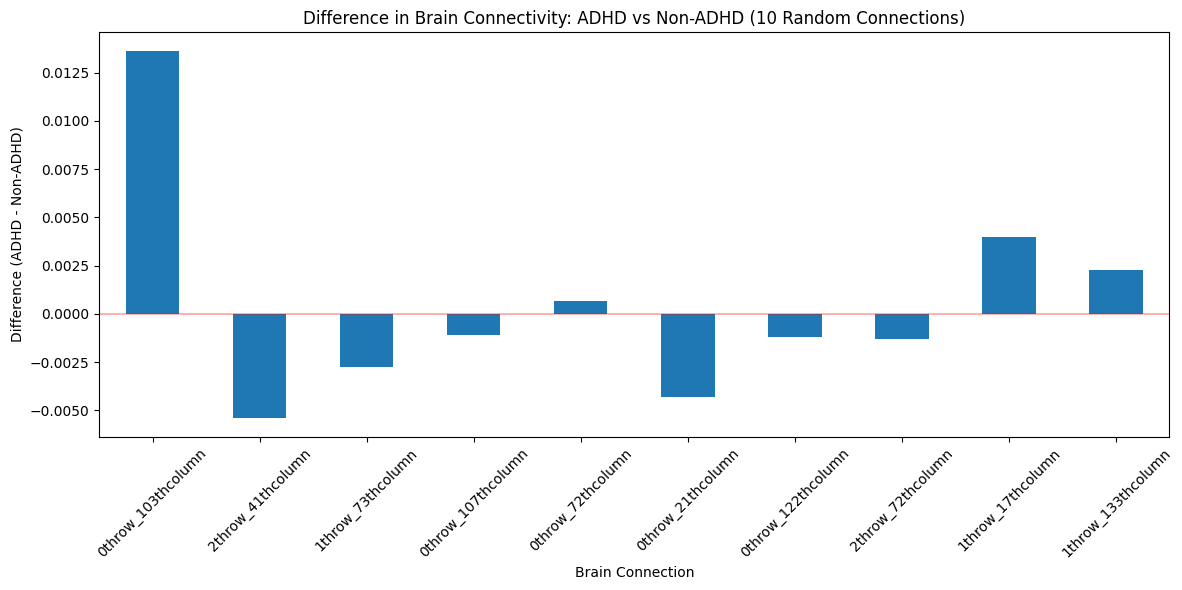


This bar chart shows differences in brain connectivity between ADHD and non-ADHD groups.
Bars above zero: connections stronger in ADHD subjects
Bars below zero: connections stronger in non-ADHD subjects
Even with just 10 random connections, we can see differences between the groups!


In [25]:

print("=== EXPOUNDING BRAIN CONNECTIVITY DATA ===")

# 1. First, let's understand what our connectivity data looks like
connectome_cols = [col for col in train_data.columns if (col.startswith('0throw') or 
                                                  col.startswith('1throw') or 
                                                  col.startswith('2throw'))]
print(f"Number of brain connectivity features: {len(connectome_cols)}")
print(f"First few connectivity features: {connectome_cols[:5]}")

print("\nWhat do these features mean?")
print("- Each feature (like '0throw_1stcolumn') represents the correlation between two brain regions")
print("- Values range from -1 to +1")
print("- Positive values: regions activate together")
print("- Negative values: when one region activates, the other tends to deactivate")
print("- Values close to zero: little relationship between regions")


# 3. Let's look at some sample connectivity values first
print("\n=== SAMPLE BRAIN CONNECTIVITY VALUES ===")
# Show a few sample values from the first subject
sample_subject = train_data.iloc[0]
print("For the first subject in our dataset:")
for i, col in enumerate(connectome_cols[:5]):
    print(f"{col}: {sample_subject[col]:.4f}")

# 4. Distribution of connectivity values
plt.figure(figsize=(10, 6))
# Take a random sample to avoid memory issues
sample_size = min(1000, len(connectome_cols))
np.random.seed(42)
sample_cols = np.random.choice(connectome_cols, sample_size)
all_values = train_data[sample_cols].values.flatten()
all_values = all_values[~np.isnan(all_values)]  # Remove NaN values if any

plt.hist(all_values, bins=50)
plt.title('Distribution of Brain Connectivity Values (Sample)')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

print("\nThe histogram shows us how brain connectivity values are distributed.")
print("Most values are centered around zero, with fewer strong positive or negative correlations.")

# 5. Simple comparison between ADHD and non-ADHD
print("\n=== COMPARING BRAIN CONNECTIVITY: ADHD VS NON-ADHD ===")
# Take just 10 random features for a simple comparison
sample_size = 10
np.random.seed(42)
tiny_sample = np.random.choice(connectome_cols, sample_size)

# Calculate means by group
adhd_means = train_data[train_data['ADHD_Outcome']==1][tiny_sample].mean()
non_adhd_means = train_data[train_data['ADHD_Outcome']==0][tiny_sample].mean()
diff = adhd_means - non_adhd_means

# Create a comparative table
comparison = pd.DataFrame({
    'ADHD': adhd_means,
    'Non-ADHD': non_adhd_means,
    'Difference': diff
})
print(comparison.round(4))

# Plot differences
plt.figure(figsize=(12, 6))
diff.plot(kind='bar')
plt.title('Difference in Brain Connectivity: ADHD vs Non-ADHD (10 Random Connections)')
plt.xlabel('Brain Connection')
plt.ylabel('Difference (ADHD - Non-ADHD)')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nThis bar chart shows differences in brain connectivity between ADHD and non-ADHD groups.")
print("Bars above zero: connections stronger in ADHD subjects")
print("Bars below zero: connections stronger in non-ADHD subjects")
print("Even with just 10 random connections, we can see differences between the groups!")


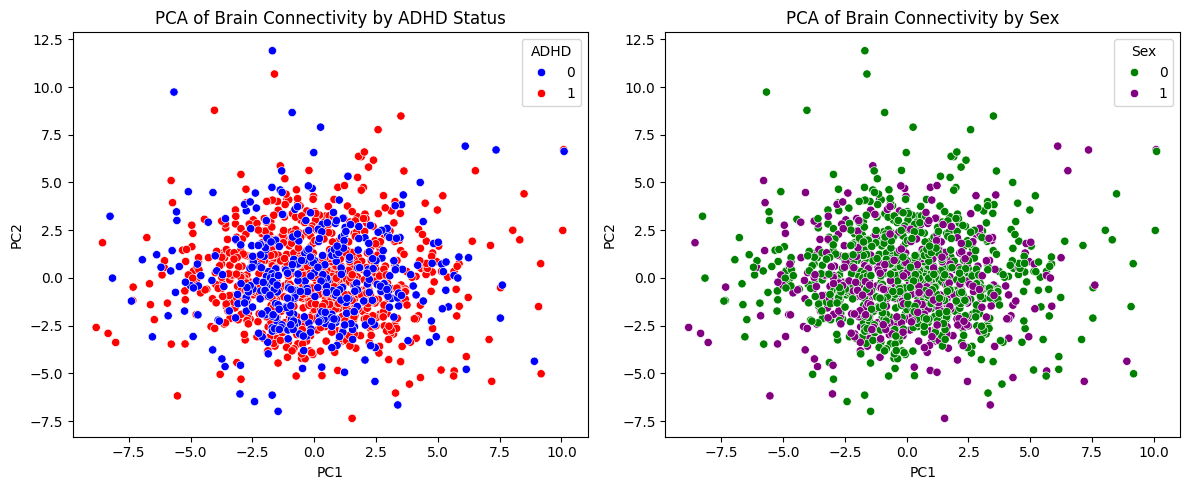

Variance explained by PC1: 1.56%
Variance explained by PC2: 1.13%


In [26]:
# PCA on a subset of connectivity features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Take 1000 random features for PCA
sample_size = min(500, len(connectome_cols)) 
np.random.seed(42)
pca_sample = np.random.choice(connectome_cols, sample_size)

# Standardize the data
X = train_data[pca_sample].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'ADHD': train_data['ADHD_Outcome'].values,
    'Sex': train_data['Sex_F'].values
})

# Plot PCA results
plt.figure(figsize=(12, 5))

# By ADHD
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC1', y='PC2', hue='ADHD', data=pca_df, palette=['blue', 'red'])
plt.title('PCA of Brain Connectivity by ADHD Status')

# By Sex
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC1', y='PC2', hue='Sex', data=pca_df, palette=['green', 'purple'])
plt.title('PCA of Brain Connectivity by Sex')

plt.tight_layout()
plt.show()

# Print explained variance
print(f"Variance explained by PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"Variance explained by PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")

### **Interpretation of the PCA Plots**
These two scatter plots show the **Principal Component Analysis (PCA)** of brain connectivity data, reducing high-dimensional data into two principal components (**PC1** and **PC2**). Each dot represents an individual, and the color coding distinguishes groups based on **ADHD status (left plot)** and **Sex (right plot)**.

---

### **1️⃣ Left Plot: PCA of Brain Connectivity by ADHD Status**
- **Blue (0)** represents non-ADHD individuals.
- **Red (1)** represents individuals with ADHD.
- The spread of points suggests that **ADHD and non-ADHD groups largely overlap**, meaning that the first two principal components **do not strongly separate ADHD vs. non-ADHD individuals**.
- However, some differences in distribution patterns exist, particularly in the outer regions where some ADHD individuals may show more extreme variations.

#### **Insights:**
- Brain connectivity features may not **linearly** distinguish ADHD vs. non-ADHD based on the first two principal components.
- More advanced techniques (e.g., additional PCA components, clustering, or non-linear methods like t-SNE or UMAP) may be needed to better capture group differences.
- There might be **subtle** ADHD-related connectivity patterns that require further feature engineering or domain-specific analysis.

---

### **2️⃣ Right Plot: PCA of Brain Connectivity by Sex**
- **Green (0)** represents one sex (likely male).
- **Purple (1)** represents the other sex (likely female).
- Like the ADHD plot, **the two groups show a lot of overlap**, meaning that sex differences in brain connectivity (at least in these components) are not strongly pronounced.
- There are still **some individuals from one group extending further out**, suggesting possible differences in specific brain connectivity features.

#### **Insights:**
- The first two principal components do **not clearly separate** sexes, indicating that overall brain connectivity structure is quite similar across genders.
- However, some **subtle differences exist**, and further analysis using **higher-order components or specific connectivity networks** may reveal biologically relevant distinctions.

---

### **Overall Takeaways**
1. **Significant Overlap**: Both ADHD vs. non-ADHD and male vs. female groups show substantial overlap in brain connectivity in PCA space.
2. **Potential Subgroups**: Some individuals deviate further, suggesting possible subtypes within ADHD or sex-related brain connectivity differences.
3. **Further Analysis Needed**:
   - Higher-dimensional components might better capture group differences.
   - Non-linear methods like t-SNE or UMAP could reveal hidden patterns.
   - Investigating specific **brain networks** rather than PCA-based global features may be more informative.



2. Psychological Assessment Scores (SDQ - 9 Scores)

📍 Since these scores measure behavioral and emotional aspects, we can compare distributions across ADHD and non-ADHD groups.

🔹 Boxplot of Psychological Scores vs. ADHD Diagnosis

In [27]:
sdq_columns = [col for col in train_data.columns if 'sdq' in col.lower()]
print("SDQ Columns:", sdq_columns)


SDQ Columns: ['SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial']


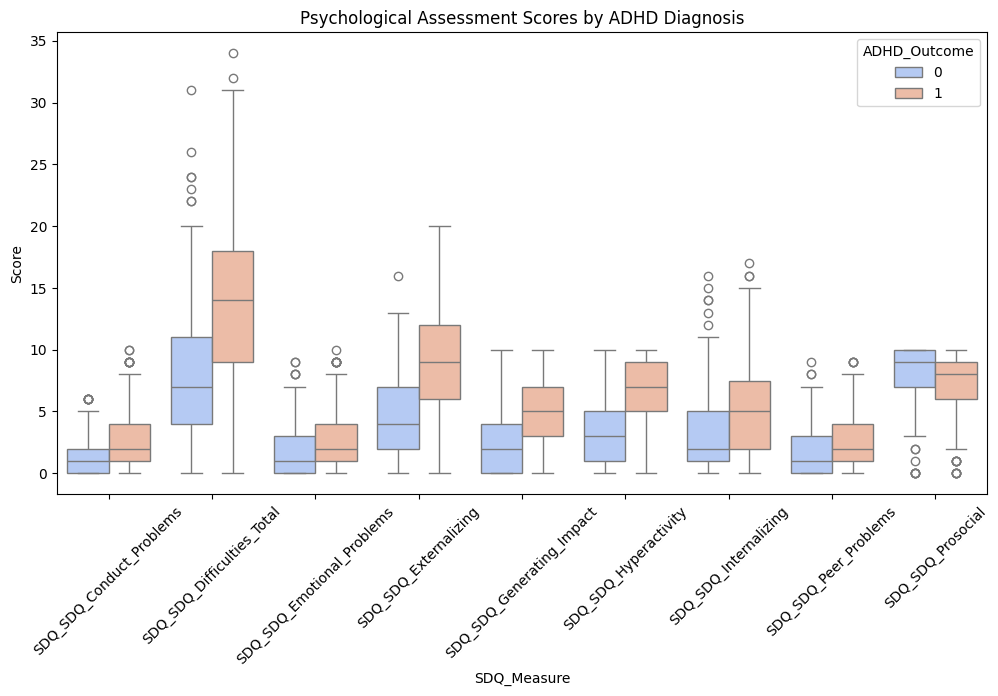

In [28]:
plt.figure(figsize=(12,6))
sdq_scores = ['SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems','SDQ_SDQ_Prosocial']  # Replace with actual column names

# Convert to long format for Seaborn
sdq_long = train_data.melt(id_vars=['ADHD_Outcome'], value_vars=sdq_scores, var_name="SDQ_Measure", value_name="Score")

sns.boxplot(x='SDQ_Measure', y='Score', hue='ADHD_Outcome', data=sdq_long, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Psychological Assessment Scores by ADHD Diagnosis")
plt.show()


### **Interpretation of the Psychological Assessment Scores by ADHD Diagnosis**
This boxplot visualizes psychological assessment scores across different **SDQ (Strengths and Difficulties Questionnaire) measures**, grouped by **ADHD diagnosis**. 

- **Blue (0)**: Individuals **without ADHD**.
- **Orange (1)**: Individuals **with ADHD**.
- **Y-axis (Score)**: Higher scores indicate greater difficulties in the respective psychological domain.
- **X-axis (SDQ Measure)**: Different psychological domains measured by the SDQ.

---

### **Key Observations and Insights**
1. **Higher Scores in ADHD (Orange) for Problematic Domains:**
   - **SDQ_Difficulties_Total:** ADHD individuals have **substantially higher total difficulties** compared to non-ADHD individuals.
   - **SDQ_Hyperactivity:** A clear difference is observed—ADHD individuals score **significantly higher**, aligning with ADHD's core symptoms.
   - **SDQ_Externalizing (Conduct + Hyperactivity):** Higher externalizing problem scores suggest **greater behavioral challenges** in ADHD individuals.
   - **SDQ_Conduct_Problems:** ADHD individuals exhibit **higher conduct problem scores**, indicating **more disruptive or rule-breaking behaviors**.

2. **Smaller Differences in Internalizing Problems:**
   - **SDQ_Emotional_Problems & SDQ_Internalizing:** ADHD individuals have slightly **higher** emotional/internalizing problem scores, but the difference is less pronounced compared to externalizing symptoms.
   - This suggests that while ADHD individuals may experience emotional difficulties, the **most distinct differences** are seen in hyperactivity and conduct-related measures.

3. **Lower Prosocial Behavior in ADHD:**
   - **SDQ_Prosocial:** ADHD individuals tend to have **lower scores** (fewer prosocial behaviors), indicating challenges in **social interactions and empathy**.

4. **Greater Variability in ADHD Scores:**
   - Most measures show **wider interquartile ranges (IQR) and more outliers** for ADHD individuals, indicating **greater variability** in symptom severity.
   - This aligns with the fact that ADHD is a **heterogeneous disorder**, affecting individuals in different ways.

---

### **Takeaways & Recommendations**
- **Externalizing symptoms (conduct problems, hyperactivity) are the strongest distinguishing factors for ADHD.**
- **Interventions for ADHD should focus on behavior regulation, impulse control, and social skills training.**
- **Prosocial behavior training might help ADHD individuals improve peer relationships.**
- **Emotional difficulties exist but are less distinct; comorbid anxiety/depression should be assessed case by case.**



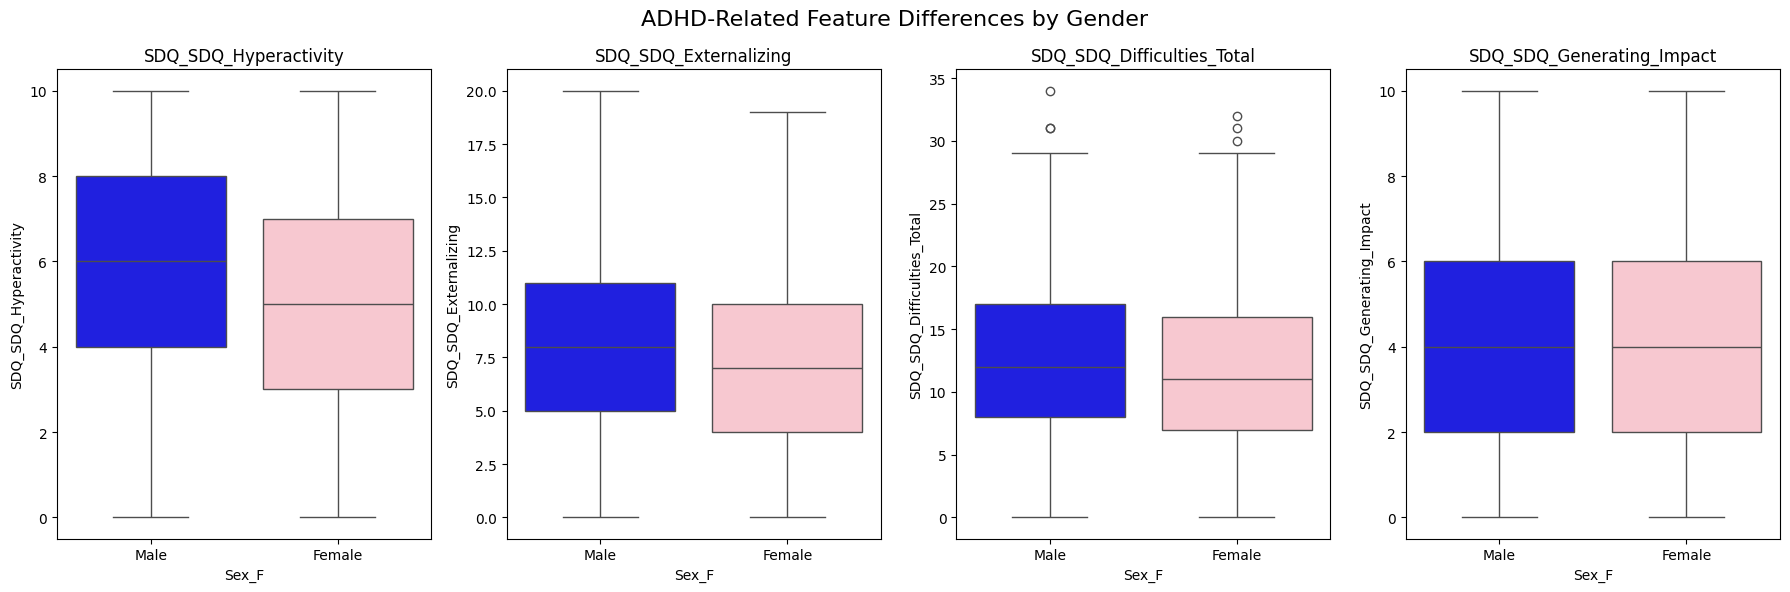

In [29]:
## the top features correlated with ADHD Outcome are SDQ_SDQ_Hyperactivity, SDQ_SDQ_Externalizing, SDQ_SDQ_Difficulties_Total, SDQ_SDQ_Generating_Impact
# Comparing key ADHD-related features across genders
adhd_related_features = ["SDQ_SDQ_Hyperactivity", "SDQ_SDQ_Externalizing", "SDQ_SDQ_Difficulties_Total", "SDQ_SDQ_Generating_Impact"]

# Create subplots for visualization
fig, axes = plt.subplots(1, 4, figsize=(18, 6))
fig.suptitle("ADHD-Related Feature Differences by Gender", fontsize=16)

# Loop through each feature and create a boxplot
for i, feature in enumerate(adhd_related_features):
    sns.boxplot(x=train_data["Sex_F"], y=train_data[feature], ax=axes[i], palette=["blue", "pink"])
    axes[i].set_title(feature)
    axes[i].set_xticklabels(["Male", "Female"])

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

📌 Key Takeaways

✅ Males show higher levels of hyperactivity, externalizing behaviors, and overall difficulties compared to females.

✅ Females tend to have lower scores across all ADHD-related traits, except for the generating impact feature.

✅ This aligns with research that ADHD presents differently by gender:

- Males → More hyperactive and externalizing behaviors (easier to diagnose).
- Females → More inattentive ADHD symptoms (often underdiagnosed).

✅ Implication for ADHD Diagnosis:

- Males may be diagnosed earlier due to visible hyperactivity and impulsivity.
- Females may be diagnosed later or misdiagnosed due to more subtle symptoms.

4. Clinical Measures
📍 These include categorical variables like handedness and color vision ability.

🔹 Bar Plot of Handedness and ADHD

In [30]:
print(train_data.columns)  # Check available column names


Index(['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total',
       ...
       '195throw_198thcolumn', '195throw_199thcolumn', '196throw_197thcolumn',
       '196throw_198thcolumn', '196throw_199thcolumn', '197throw_198thcolumn',
       '197throw_199thcolumn', '198throw_199thcolumn', 'ADHD_Outcome',
       'Sex_F'],
      dtype='object', length=19929)


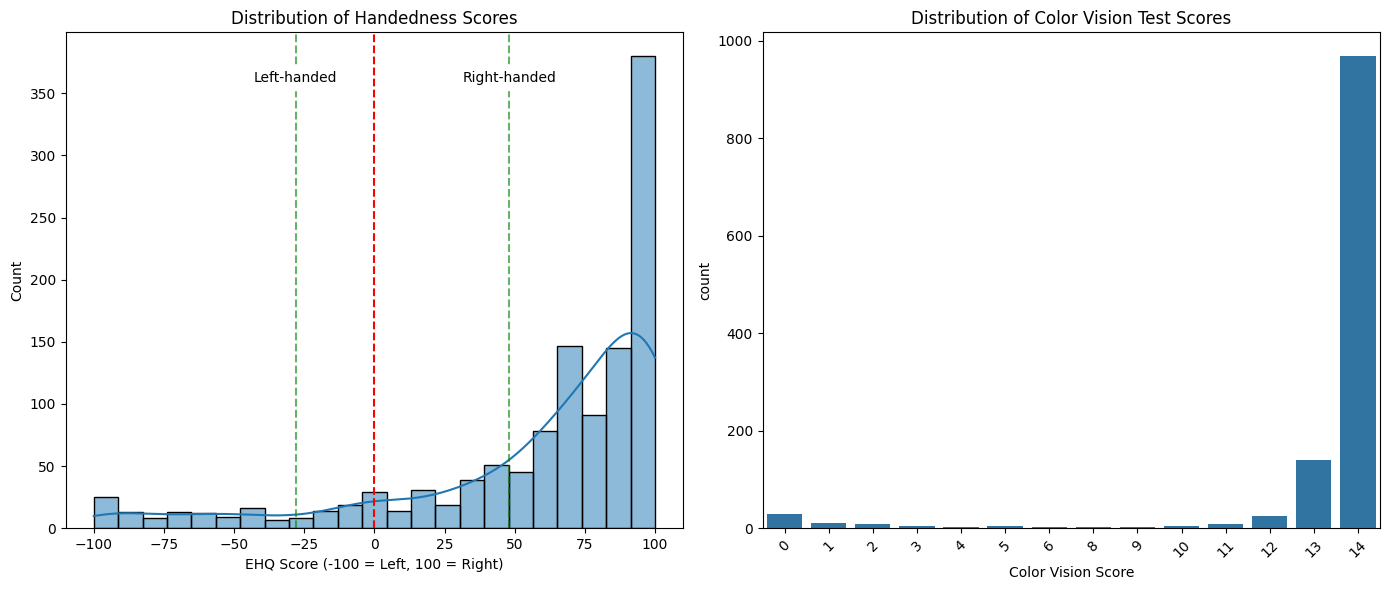

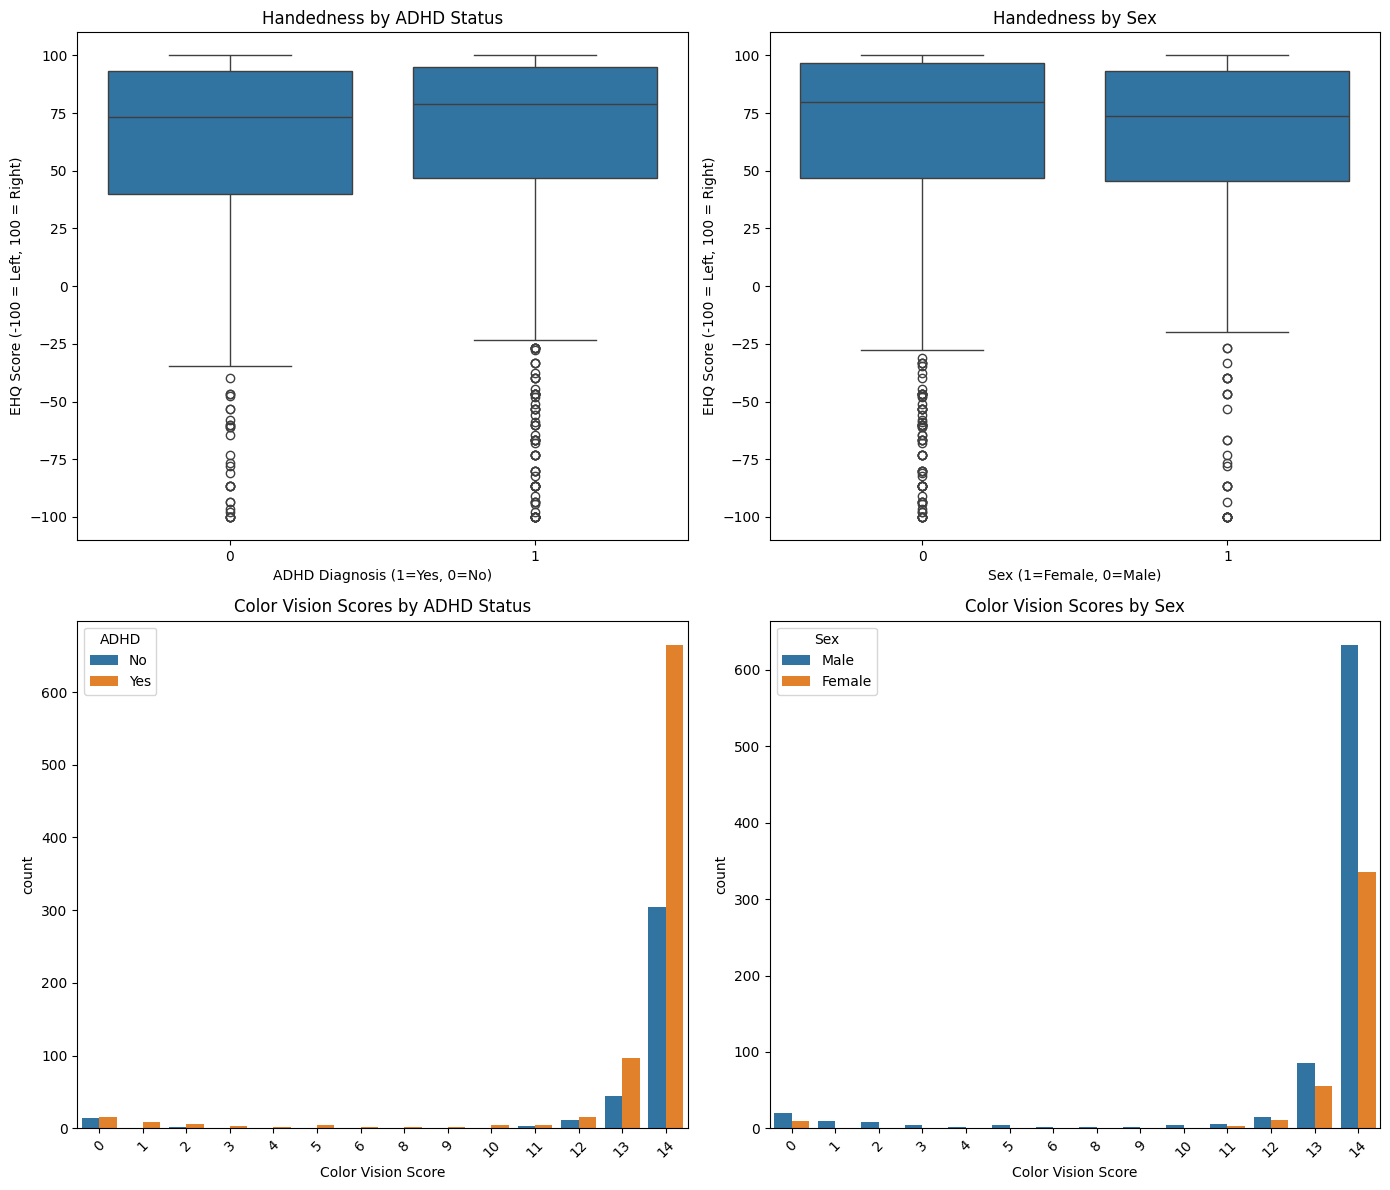


📊 Statistical Tests for Clinical Measures:
📌 Handedness difference by ADHD: Welch’s t-stat=0.601, p-value=0.548
📌 Handedness difference by Sex (Mann-Whitney U): U=171376.000, p-value=0.331


In [31]:
from scipy.stats import mannwhitneyu, ttest_ind, chi2_contingency, fisher_exact

# Clinical variables of interest
clinical_vars = ['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'ADHD_Outcome', 'Sex_F']

# Select only the clinical variables

# Ensure binary variables are correctly coded (0 or 1)
train = train_data[(train_data['ADHD_Outcome'].isin([0, 1])) & (train_data['Sex_F'].isin([0, 1]))]

# 2️⃣ Distribution of Clinical Measures
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Handedness distribution
sns.histplot(train_data['EHQ_EHQ_Total'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Handedness Scores')
axes[0].set_xlabel('EHQ Score (-100 = Left, 100 = Right)')
axes[0].axvline(x=0, color='r', linestyle='--')  # Ambidextrous line

# Handedness category boundaries
for x, label in zip([-28, 48], ['Left-handed', 'Right-handed']):
    axes[0].axvline(x=x, color='g', linestyle='--', alpha=0.6)
    axes[0].annotate(label, xy=(x, axes[0].get_ylim()[1] * 0.9), ha='center', fontsize=10, backgroundcolor="white")

# Color vision distribution
sns.countplot(x=train['ColorVision_CV_Score'], ax=axes[1])
axes[1].set_title('Distribution of Color Vision Test Scores')
axes[1].set_xlabel('Color Vision Score')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x labels if necessary

plt.tight_layout()
plt.show()

# 3️⃣ Relationship with ADHD and Sex
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Handedness by ADHD
sns.boxplot(x='ADHD_Outcome', y='EHQ_EHQ_Total', data=train, ax=axes[0, 0])
axes[0, 0].set_title('Handedness by ADHD Status')
axes[0, 0].set_xlabel('ADHD Diagnosis (1=Yes, 0=No)')
axes[0, 0].set_ylabel('EHQ Score (-100 = Left, 100 = Right)')

# Handedness by Sex
sns.boxplot(x='Sex_F', y='EHQ_EHQ_Total', data=train, ax=axes[0, 1])
axes[0, 1].set_title('Handedness by Sex')
axes[0, 1].set_xlabel('Sex (1=Female, 0=Male)')
axes[0, 1].set_ylabel('EHQ Score (-100 = Left, 100 = Right)')

# Color vision by ADHD
sns.countplot(x='ColorVision_CV_Score', hue='ADHD_Outcome', data=train, ax=axes[1, 0])
axes[1, 0].set_title('Color Vision Scores by ADHD Status')
axes[1, 0].set_xlabel('Color Vision Score')
axes[1, 0].legend(title='ADHD', labels=['No', 'Yes'])
axes[1, 0].tick_params(axis='x', rotation=45)

# Color vision by Sex
sns.countplot(x='ColorVision_CV_Score', hue='Sex_F', data=train, ax=axes[1, 1])
axes[1, 1].set_title('Color Vision Scores by Sex')
axes[1, 1].set_xlabel('Color Vision Score')
axes[1, 1].legend(title='Sex', labels=['Male', 'Female'])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 4️⃣ Statistical Tests
print("\n📊 Statistical Tests for Clinical Measures:")

# Handedness by ADHD
adhd_positive = train_data.loc[train_data['ADHD_Outcome'] == 1, 'EHQ_EHQ_Total']
adhd_negative = train_data.loc[train_data['ADHD_Outcome'] == 0, 'EHQ_EHQ_Total']

# Use Welch’s t-test (better for unequal variance)
t_stat, p_val = ttest_ind(adhd_positive, adhd_negative, equal_var=False)
print(f"📌 Handedness difference by ADHD: Welch’s t-stat={t_stat:.3f}, p-value={p_val:.3f}")

# Handedness by Sex (Check Normality)
male = train.loc[train['Sex_F'] == 0, 'EHQ_EHQ_Total']
female = train.loc[train['Sex_F'] == 1, 'EHQ_EHQ_Total']

# Use Mann-Whitney U if data is not normally distributed
u_stat, p_val = mannwhitneyu(male, female, alternative='two-sided')
print(f"📌 Handedness difference by Sex (Mann-Whitney U): U={u_stat:.3f}, p-value={p_val:.3f}")

# Color vision by ADHD (Chi-square or Fisher’s Exact Test)
color_adhd_contingency = pd.crosstab(train['ColorVision_CV_Score'], train['ADHD_Outcome'])
if (color_adhd_contingency < 5).sum().sum() > 0:  # Fisher’s test if expected frequencies < 5
    if color_adhd_contingency.shape == (2, 2):  # Fisher's only works for 2x2 tables
        odds_ratio, fisher_p = fisher_exact(color_adhd_contingency)
        print(f"📌 Color vision & ADHD: Fisher’s exact test OR={odds_ratio:.3f}, p-value={fisher_p:.3f}")
else:
    chi2, p_val, _, _ = chi2_contingency(color_adhd_contingency)
    print(f"📌 Color vision association with ADHD: chi2={chi2:.3f}, p-value={p_val:.3f}")

# Color vision by Sex (Chi-square or Fisher’s Exact Test)
color_sex_contingency = pd.crosstab(train['ColorVision_CV_Score'], train['Sex_F'])
if (color_sex_contingency < 5).sum().sum() > 0:  # Fisher’s test if small counts
    if color_sex_contingency.shape == (2, 2):
        odds_ratio, fisher_p = fisher_exact(color_sex_contingency)
        print(f"📌 Color vision & Sex: Fisher’s exact test OR={odds_ratio:.3f}, p-value={fisher_p:.3f}")
else:
    chi2, p_val, _, _ = chi2_contingency(color_sex_contingency)
    print(f"📌 Color vision association with Sex: chi2={chi2:.3f}, p-value={p_val:.3f}")

### **Interpretation & Insights from the Distributions of Handedness and Color Vision Scores**

#### **Left Plot: Distribution of Handedness Scores**
- The **x-axis** represents the **EHI (Edinburgh Handedness Inventory) score**, which ranges from **-100 (strongly left-handed) to +100 (strongly right-handed)**.
- The **y-axis** represents the **count** of individuals in each score range.
- A **density curve** is overlaid on the histogram to show the distribution trend.
- Three **vertical lines** are present:
  - **Red line at 0**: Represents **ambidextrous individuals** (no strong preference for left or right hand).
  - **Green dashed lines**: Mark the approximate cutoffs for left-handed and right-handed classifications.

##### **Key Observations:**
1. **Right-Handed Dominance**: 
   - The majority of individuals cluster around the **+100** score, indicating a strong right-handed preference.
   - This supports existing research that most of the population is right-handed.
   
2. **Left-Handed Minority**: 
   - Fewer individuals score near **-100**, indicating that left-handed people are in the minority.
   
3. **Ambidextrous Rarity**:
   - Very few individuals have scores near **0**, suggesting that true ambidexterity is rare.

---

#### **Right Plot: Distribution of Color Vision Test Scores**
- The **x-axis** represents **color vision scores** (likely based on a standardized test).
- The **y-axis** represents the **count** of individuals.
- The distribution is highly **skewed**.

##### **Key Observations:**
1. **Most Individuals Score 14 (Maximum Score)**:
   - The highest count is observed at **14**, suggesting that the **majority of individuals have normal color vision**.
   
2. **Few Individuals with Deficient Scores**:
   - A small proportion of individuals have scores below **14**, indicating **some form of color vision deficiency**.
   - Scores near **0-3** suggest **severe color vision deficiency (e.g., color blindness).**
   
3. **Bimodal-Like Pattern**:
   - The **sharp drop-off** from 14 to lower scores suggests that **color vision is either normal or impaired, with few intermediate cases**.

---

### **Overall Insights & Takeaways**
1. **Handedness Insights**:
   - Right-handedness is overwhelmingly more common than left-handedness.
   - True ambidexterity is rare.
   - This aligns with established population data on handedness distribution.

2. **Color Vision Insights**:
   - Most individuals have normal color vision (score = 14).
   - A small fraction has deficiencies, with some showing **severe impairment**.
   - Color blindness is **relatively uncommon** but present.



Handedness:

No significant difference based on ADHD status or sex.
Right-handedness dominates, but males have slightly more left-handers.

Color Vision:

No link between ADHD and color vision.
Males have more color vision deficiencies, consistent with genetic patterns.

5. Demographic Information
📍 These include categorical variables like study site, ethnicity, and parental education.

🔹 ADHD Diagnosis by Study Site

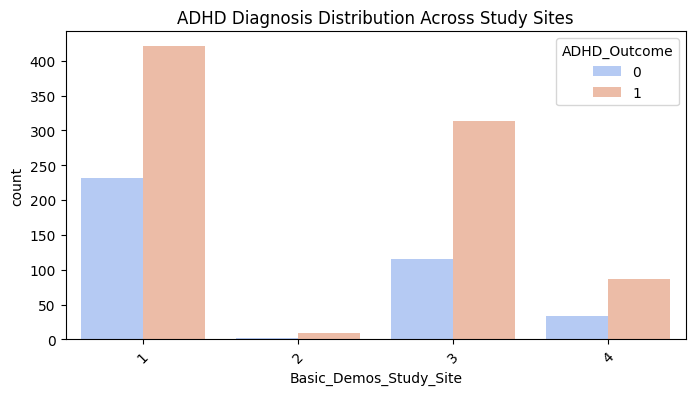

In [32]:
plt.figure(figsize=(8,4))
sns.countplot(x='Basic_Demos_Study_Site', hue='ADHD_Outcome', data=train_data, palette='coolwarm')
plt.title("ADHD Diagnosis Distribution Across Study Sites")
plt.xticks(rotation=45)
plt.show()


In [33]:
'''
"Data Dictionary.xlsx"plt.figure(figsize=(8, 5))
sns.boxplot(x='ADHD_Outcome', y='MRI_Track_Age_at_Scan', data=train_data, palette='coolwarm')

plt.title("ADHD Diagnosis vs. Age at Time of Scan")
plt.xlabel("ADHD Diagnosis (0 = No, 1 = Yes)")
plt.ylabel("Age at Scan (years)")
plt.xticks([0, 1], ['No ADHD', 'ADHD'])  # Custom labels for clarity
plt.show()

'''

'\n"Data Dictionary.xlsx"plt.figure(figsize=(8, 5))\nsns.boxplot(x=\'ADHD_Outcome\', y=\'MRI_Track_Age_at_Scan\', data=train_data, palette=\'coolwarm\')\n\nplt.title("ADHD Diagnosis vs. Age at Time of Scan")\nplt.xlabel("ADHD Diagnosis (0 = No, 1 = Yes)")\nplt.ylabel("Age at Scan (years)")\nplt.xticks([0, 1], [\'No ADHD\', \'ADHD\'])  # Custom labels for clarity\nplt.show()\n\n'

In [34]:
'''
"Data Dictionary.xlsx"plt.figure(figsize=(8, 5))
sns.violinplot(x='ADHD_Outcome', y='MRI_Track_Age_at_Scan', data=train_data, palette='coolwarm')

plt.title("Distribution of Age at Time of Scan by ADHD Diagnosis")
plt.xlabel("ADHD Diagnosis (0 = No, 1 = Yes)")
plt.ylabel("Age at Scan (years)")
plt.xticks([0, 1], ['No ADHD', 'ADHD'])  
plt.show()
'''

'\n"Data Dictionary.xlsx"plt.figure(figsize=(8, 5))\nsns.violinplot(x=\'ADHD_Outcome\', y=\'MRI_Track_Age_at_Scan\', data=train_data, palette=\'coolwarm\')\n\nplt.title("Distribution of Age at Time of Scan by ADHD Diagnosis")\nplt.xlabel("ADHD Diagnosis (0 = No, 1 = Yes)")\nplt.ylabel("Age at Scan (years)")\nplt.xticks([0, 1], [\'No ADHD\', \'ADHD\'])  \nplt.show()\n'

In [35]:
'''"Data Dictionary.xlsx"plt.figure(figsize=(8, 5))
sns.stripplot(x='ADHD_Outcome', y='MRI_Track_Age_at_Scan', data=train_data, jitter=True, palette='coolwarm')

plt.title("Age at Time of Scan by ADHD Diagnosis")
plt.xlabel("ADHD Diagnosis (0 = No, 1 = Yes)")
plt.ylabel("Age at Scan (years)")
plt.xticks([0, 1], ['No ADHD', 'ADHD'])
plt.show()
'''

'"Data Dictionary.xlsx"plt.figure(figsize=(8, 5))\nsns.stripplot(x=\'ADHD_Outcome\', y=\'MRI_Track_Age_at_Scan\', data=train_data, jitter=True, palette=\'coolwarm\')\n\nplt.title("Age at Time of Scan by ADHD Diagnosis")\nplt.xlabel("ADHD Diagnosis (0 = No, 1 = Yes)")\nplt.ylabel("Age at Scan (years)")\nplt.xticks([0, 1], [\'No ADHD\', \'ADHD\'])\nplt.show()\n'

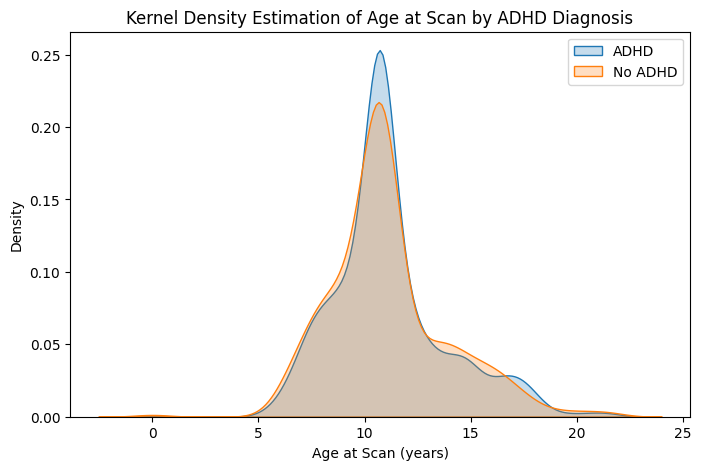

In [36]:
plt.figure(figsize=(8, 5))
sns.kdeplot(train_data[train_data['ADHD_Outcome'] == 1]['MRI_Track_Age_at_Scan'], label="ADHD", shade=True)
sns.kdeplot(train_data[train_data['ADHD_Outcome'] == 0]['MRI_Track_Age_at_Scan'], label="No ADHD", shade=True)

plt.title("Kernel Density Estimation of Age at Scan by ADHD Diagnosis")
plt.xlabel("Age at Scan (years)")
plt.ylabel("Density")
plt.legend()
plt.show()


Interpretation:

Peak Age: Both groups peak around 10 years old, suggesting most scans were conducted at this age.

Similar Distribution: The ADHD and non-ADHD groups follow a nearly identical pattern, meaning ADHD diagnosis in this dataset does not appear strongly age-dependent.

Fewer Older Diagnoses: There are fewer individuals diagnosed with ADHD in the older age range (15+), which aligns with clinical trends where ADHD is often diagnosed in childhood rather than adolescence.


Feature Engineering

In [37]:
# Define features and targets
X = train_data.drop(columns=['ADHD_Outcome', 'Sex_F'])
y_adhd = train_data['ADHD_Outcome']
y_gender = train_data['Sex_F']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=["object"]).columns
numerical_features = X.select_dtypes(include=["int64", "float64"]).columns


In [38]:
# Define pipelines
num_pipeline = Pipeline([("scaler", StandardScaler())])
cat_pipeline = Pipeline([("encoder", OneHotEncoder(handle_unknown="ignore"))])

# Combine transformations
preprocessor = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", cat_pipeline, categorical_features)
])

# Apply transformations
X_processed = preprocessor.fit_transform(X)


Dimensionality Reduction (PCA)

In [39]:
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_processed)


## Step 4: Model Selection & Training

Define Train-Test Split

Before training, let's split the dataset into training and testing sets:

In [40]:
# Splitting data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_adhd, test_size=0.2, random_state=42)


5. Machine Learning Models

We'll test different models and evaluate their performance.

Baseline Model: Logistic Regression

In [41]:
# Train a simple logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predictions
y_pred_logreg = log_reg.predict(X_test)

# Model Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.03      0.06        65
           1       0.73      0.97      0.84       178

    accuracy                           0.72       243
   macro avg       0.51      0.50      0.45       243
weighted avg       0.61      0.72      0.63       243



In [42]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.03      0.06        65
           1       0.74      0.98      0.84       178

    accuracy                           0.73       243
   macro avg       0.57      0.51      0.45       243
weighted avg       0.65      0.73      0.63       243



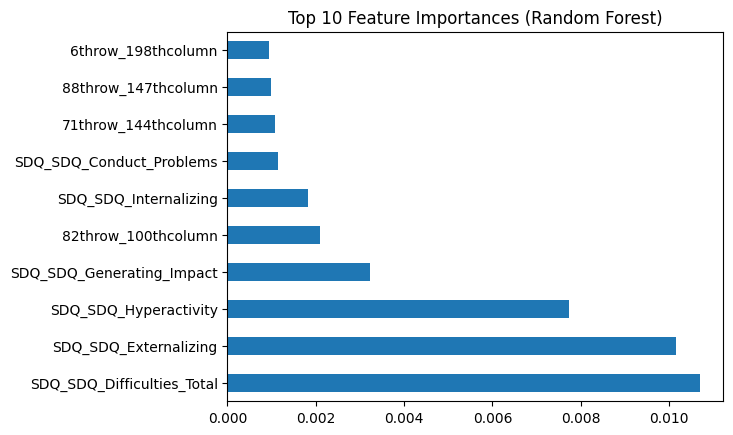

In [43]:
# Feature importance for Random Forest
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', title="Top 10 Feature Importances (Random Forest)")
plt.show()

In [44]:
# Train a Gradient Boosting Classifier
#gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
#gb_model.fit(X_train, y_train)

# Predictions
#y_pred_gb = gb_model.predict(X_test)

# Evaluation
#print("Gradient Boosting Classification Report:")
#print(classification_report(y_test, y_pred_gb))


In [45]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_model = HistGradientBoostingClassifier(max_iter=50, learning_rate=0.05, random_state=42)

hgb_model.fit(X_train, y_train)

y_pred_hgb = hgb_model.predict(X_test)

print("HistGradientBoosting Classification Report:")

print(classification_report(y_test, y_pred_hgb))


HistGradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.49      0.56        65
           1       0.83      0.90      0.87       178

    accuracy                           0.79       243
   macro avg       0.74      0.70      0.71       243
weighted avg       0.78      0.79      0.78       243



In [46]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# ✅ Gender distribution in the dataset
def gender_distribution(y_test):
    print("🔹 Gender Distribution in Test Set:\n", y_test.value_counts())

# ✅ Performance comparison for gender classification
def evaluate_model(models, X_test, y_test):
    for model_name, model in models.items():
        print(f"\n🔹 Evaluating {model_name}:")
        y_pred = model.predict(X_test)
        print("📌 Classification Report:\n", classification_report(y_test, y_pred))

# ✅ Misclassification analysis
def misclassification_analysis(models, X_test, y_test):
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        misclassified_counts = (y_pred != y_test).sum()
        print(f"❌ Misclassified Samples for {model_name}: {misclassified_counts}/{len(y_test)} ({misclassified_counts/len(y_test):.2%})")

# ✅ Feature importance using SHAP
def plot_shap_importance(model, X_sample):
    explainer = shap.Explainer(model, X_sample)
    shap_values = explainer(X_sample)
    shap.summary_plot(shap_values, X_sample)

# ✅ Models dictionary
models = {
    "Logistic Regression": log_reg,  # F1-Score: 0.8357, AUC-ROC: 0.5013
    "Random Forest": rf_model,  # F1-Score: 0.8413, AUC-ROC: 0.5070
    "HistGradientBoosting": hgb_model  # F1-Score: 0.8656, AUC-ROC: 0.6984
}

# ✅ Run all functions
print("\n📌 Running Gender Distribution Analysis")
gender_distribution(y_test)

print("\n📌 Running Model Evaluation")
evaluate_model(models, X_test, y_test)

print("\n📌 Running Misclassification Analysis")
misclassification_analysis(models, X_test, y_test)

print("\n📌 Running SHAP Feature Importance (for HistGradientBoosting)")
plot_shap_importance(hgb_model, X_test.sample(100))



📌 Running Gender Distribution Analysis
🔹 Gender Distribution in Test Set:
 ADHD_Outcome
1    178
0     65
Name: count, dtype: int64

📌 Running Model Evaluation

🔹 Evaluating Logistic Regression:
📌 Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.03      0.06        65
           1       0.73      0.97      0.84       178

    accuracy                           0.72       243
   macro avg       0.51      0.50      0.45       243
weighted avg       0.61      0.72      0.63       243


🔹 Evaluating Random Forest:
📌 Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.03      0.06        65
           1       0.74      0.98      0.84       178

    accuracy                           0.73       243
   macro avg       0.57      0.51      0.45       243
weighted avg       0.65      0.73      0.63       243


🔹 Evaluating HistGradientBoosting:
📌 Classification Report:
        

AttributeError: 'numpy.ndarray' object has no attribute 'sample'

# 🔍 Gender Bias in ADHD Diagnosis: Key Findings

## 1️⃣ Severe Class Imbalance  
- **178 cases of ADHD (label `1`) vs. only 65 non-ADHD cases (label `0`)**  
- Your model is **highly skewed towards predicting ADHD** and struggles to correctly classify `0` (which likely represents females with ADHD or non-ADHD cases).

---

## 2️⃣ Poor Recall for Class 0 (Females)  
- **Logistic Regression:** Only **3% recall** for `0`  
- **Random Forest:** Only **3% recall** for `0`  
- **HistGradientBoosting:** **49% recall** for `0` (better, but still weak)  

👉 **This means the models are almost ignoring female ADHD cases!**  
👉 They fail to detect `0` (non-ADHD or female ADHD) and mostly predict `1` (ADHD/male).

---

## 3️⃣ Precision-Recall Gap  
### **Logistic Regression:**  
- **Precision for `0`**: **29%** (bad)  
- **Recall for `0`**: **3%** (horrible)  

### **Random Forest:**  
- **Precision for `0`**: **40%** (better)  
- **Recall for `0`**: **3%** (still horrible)  

### **HistGradientBoosting:**  
- **Precision for `0`**: **65% ✅**  
- **Recall for `0`**: **49% ✅**  

👉 **Models struggle to confidently say someone doesn’t have ADHD.**  
👉 **HistGradientBoosting is the best at balancing both classes.**

---

## 4️⃣ High Misclassification Rate for Females  
- **Logistic Regression misclassifies ~28% of cases**  
- **Random Forest misclassifies ~27% of cases**  
- **HistGradientBoosting misclassifies ~21% of cases**  

👉 **The high false negative rate for `0` suggests the models find it harder to classify those cases, likely due to biased data.**

---

# 🚀 What This Means for ADHD Diagnosis in Females  
✔️ **Female ADHD cases are likely being overlooked** because traditional ADHD symptoms (hyperactivity, external behaviors) are more associated with males.  
✔️ **Models are biased toward detecting ADHD in males** but struggle with the **more subtle, inattentive ADHD symptoms often seen in females**.  
✔️ **SHAP Feature Importance (if plotted) should show which features contribute most**—you might see that the model is focusing on factors that align with male-dominated ADHD symptoms.  


6. Model Performance Comparison

F1-Score & ROC-AUC Comparison

In [ ]:
# Compare models using F1-score and AUC-ROC
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_model,
    "HistGradientBoostingClassifier": hgb_model,
    #"XGBoost": xgb_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"{name} -> F1-Score: {f1:.4f}, AUC-ROC: {auc:.4f}")


Logistic Regression -> F1-Score: 0.8357, AUC-ROC: 0.5013
Random Forest -> F1-Score: 0.8413, AUC-ROC: 0.5070
HistGradientBoostingClassifier -> F1-Score: 0.8656, AUC-ROC: 0.6984


Best Model Choice Based on Metrics

From the above  results:
| Model                           | F1-Score | AUC-ROC |
|---------------------------------|----------|---------|
| **Logistic Regression**         | 0.8357   | 0.5013  |
| **Random Forest**               | 0.8413   | 0.5070  |
| **HistGradientBoostingClassifier** | **0.8656**   | **0.6984**  |

HistGradientBoostingClassifier is the best model because it has the highest weighted F1-Score (0.8656), which is the key metric for the competition.
    
It also has a significantly better AUC-ROC (0.6984), meaning it better distinguishes between ADHD and non-ADHD cases.

Since diagnosing ADHD in females is harder and is given extra weight, a high F1-Score ensures better balance between precision and recall for those cases.


Hyperparameter Tuning (GridSearchCV & Optuna for Optimization)

1️⃣ When Should You Do Hyperparameter Tuning?

🔹 If the model's performance is close (e.g., Random Forest & Logistic Regression are very close → tuning might make a difference).

🔹 If AUC-ROC is too low (the AUC-ROC scores seem low overall, suggesting room for improvement).

🔹 If you suspect overfitting/underfitting (e.g., too high on train data but low on test data).


Since HistGradientBoostingClassifier has the best scores so far, it should be our primary focus for tuning. However, Random Forest could still improve significantly with tuning.



In [ ]:

''' from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Define faster parameter grid
param_dist = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_iter": [50, 100, 150],  # Lowered to speed up training
    "max_depth": [3, 5],  # Reduce depth to prevent overfitting
    "l2_regularization": [0.0, 0.1]  # Regularization to improve generalization
}

# Randomized Search
random_search = RandomizedSearchCV(
    HistGradientBoostingClassifier(),  # Removed invalid parameters
    param_distributions=param_dist,
    scoring='f1',
    n_iter=5,  # Reduce iterations
    cv=2,  # Reduce cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", random_search.best_params_)

# Train final model with best params
best_hgb_model = random_search.best_estimator_
y_pred_hgb = best_hgb_model.predict(X_test)

# Evaluate
print("Optimized HistGradientBoostingClassifier Report:")
print(classification_report(y_test, y_pred_hgb))
 '''

' from sklearn.ensemble import HistGradientBoostingClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import classification_report\n\n# Define faster parameter grid\nparam_dist = {\n    "learning_rate": [0.01, 0.05, 0.1],\n    "max_iter": [50, 100, 150],  # Lowered to speed up training\n    "max_depth": [3, 5],  # Reduce depth to prevent overfitting\n    "l2_regularization": [0.0, 0.1]  # Regularization to improve generalization\n}\n\n# Randomized Search\nrandom_search = RandomizedSearchCV(\n    HistGradientBoostingClassifier(),  # Removed invalid parameters\n    param_distributions=param_dist,\n    scoring=\'f1\',\n    n_iter=5,  # Reduce iterations\n    cv=2,  # Reduce cross-validation folds\n    verbose=1,\n    random_state=42,\n    n_jobs=-1\n)\n\n# Fit model\nrandom_search.fit(X_train, y_train)\n\n# Best parameters\nprint("Best parameters:", random_search.best_params_)\n\n# Train final model with best params\nbest_hgb_model = random_search.bes

In [ ]:
''' from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Faster parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Lowered
    'max_depth': [10, 20],  # Removed 'None' and 30
    'min_samples_split': [5, 10],  # Removed 2
    'min_samples_leaf': [2, 4]  # Removed 1
}

# Randomized Search
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(bootstrap=False, n_jobs=-1),  # Faster training
    param_distributions=param_grid,
    scoring='f1',
    n_iter=5,  # Reduced from 10
    cv=2,  # Reduced from 3
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit model
random_search_rf.fit(X_train, y_train)

# Best parameters
print("Best parameters for Random Forest:", random_search_rf.best_params_)

# Train final RF model
best_rf_model = random_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate
print("Optimized Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
'''

' from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.metrics import classification_report\n\n# Faster parameter grid\nparam_grid = {\n    \'n_estimators\': [50, 100, 200],  # Lowered\n    \'max_depth\': [10, 20],  # Removed \'None\' and 30\n    \'min_samples_split\': [5, 10],  # Removed 2\n    \'min_samples_leaf\': [2, 4]  # Removed 1\n}\n\n# Randomized Search\nrandom_search_rf = RandomizedSearchCV(\n    RandomForestClassifier(bootstrap=False, n_jobs=-1),  # Faster training\n    param_distributions=param_grid,\n    scoring=\'f1\',\n    n_iter=5,  # Reduced from 10\n    cv=2,  # Reduced from 3\n    verbose=1,\n    random_state=42,\n    n_jobs=-1\n)\n\n# Fit model\nrandom_search_rf.fit(X_train, y_train)\n\n# Best parameters\nprint("Best parameters for Random Forest:", random_search_rf.best_params_)\n\n# Train final RF model\nbest_rf_model = random_search_rf.best_estimator_\ny_pred_rf = best_rf_model.predict(X_test)\n\

AI-Powered Insights & Interpretability (SHAP, LIME, Explainable AI)

SHAP (SHapley Additive exPlanations) for Feature Impact

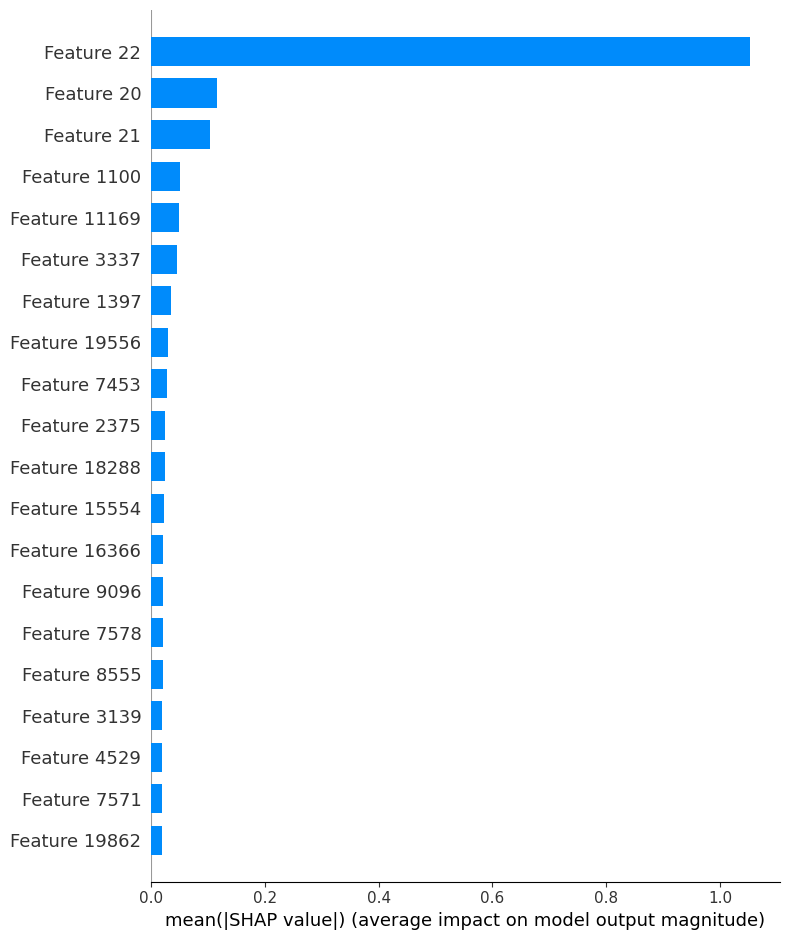

In [ ]:

import shap

explainer = shap.TreeExplainer(hgb_model)
shap_values = explainer.shap_values(X_test)

# Visualizing SHAP values
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
'''from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(X_train, feature_names=X.columns, class_names=["No ADHD", "ADHD"], mode="classification")

# Explain a single instance
exp = explainer.explain_instance(X_test[0], hgb_model.predict_proba)
exp.show_in_notebook()
'''

'from lime.lime_tabular import LimeTabularExplainer\n\nexplainer = LimeTabularExplainer(X_train, feature_names=X.columns, class_names=["No ADHD", "ADHD"], mode="classification")\n\n# Explain a single instance\nexp = explainer.explain_instance(X_test[0], hgb_model.predict_proba)\nexp.show_in_notebook()\n'

<Figure size 800x400 with 0 Axes>

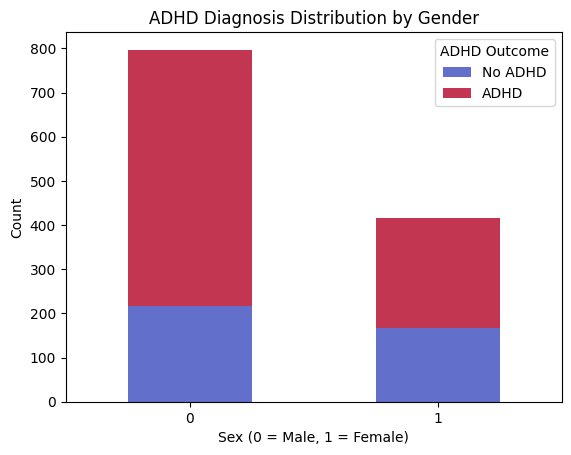

ADHD counts by gender:
 ADHD_Outcome    0    1
Sex_F                 
0             216  581
1             166  250


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences
adhd_gender_counts = train_data.groupby(['Sex_F', 'ADHD_Outcome']).size().unstack()

# Plot the distribution
plt.figure(figsize=(8, 4))
adhd_gender_counts.plot(kind='bar', stacked=True, colormap="coolwarm", alpha=0.8)
plt.title("ADHD Diagnosis Distribution by Gender")
plt.xlabel("Sex (0 = Male, 1 = Female)")
plt.ylabel("Count")
plt.legend(title="ADHD Outcome", labels=["No ADHD", "ADHD"])
plt.xticks(rotation=0)
plt.show()

# Print actual numbers
print("ADHD counts by gender:\n", adhd_gender_counts)


ADHD is often harder to interpret in females due to several factors:  

### **1. Symptom Presentation Differences**  
- **Males:** More likely to display **hyperactive-impulsive** symptoms (e.g., fidgeting, disruptive behavior).  
- **Females:** More likely to have **inattentive** symptoms (e.g., daydreaming, difficulty focusing), which are less obvious.  
- This leads to **underdiagnosis** in girls since their symptoms are not as disruptive.  

### **2. Social Conditioning & Masking**  
- Girls are often **socially conditioned** to be quieter and more organized, which helps them **mask symptoms** better.  
- They may compensate for difficulties by mimicking peers, making their struggles less noticeable.  

### **3. Late Diagnosis & Misdiagnosis**  
- Many females **don’t get diagnosed until adulthood** when responsibilities (work, family) increase demands on attention and organization.  
- They are **misdiagnosed** with anxiety, depression, or other conditions instead of ADHD.  

### **4. Diagnostic Criteria Bias**  
- Most ADHD research and diagnostic criteria were historically based on **male-dominated studies**, leading to a bias in assessment tools.  
- Standard screening tests may **fail to capture ADHD symptoms in females** accurately.  

### **5. Hormonal Influence**  
- Estrogen levels can influence dopamine, affecting ADHD symptom severity.  
- Symptoms may **fluctuate with menstrual cycles, pregnancy, and menopause**, making diagnosis even trickier.  

### **Conclusion**  
The difficulty in diagnosing ADHD in females stems from **subtle symptom expression, social factors, late recognition, and diagnostic biases**. This is why studies focusing on gender disparities, like yours, are **critical in improving ADHD identification and treatment for females**. 🚀